In [1]:
import math
import numpy as np
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from multiprocessing import Pool, cpu_count
import community  # Louvain algorithm package

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
features_df = pd.read_csv('extracted_features.csv', index_col='Unnamed: 0')
features_df.tail(10)

,area,perimeter,eccentricity,solidity,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,mean_intensity,std_intensity,label
3382,1.0,0.0,0.0,1.0,498.0,589.0,478.0,684.0,916.0,699.0,376.0,60528.0,0.076085,0.246714,ID192_A1_Regione-1.jp2-crop_slice_105/63_label...
3383,1.0,0.0,0.0,1.0,442.0,551.0,470.0,700.0,1007.0,656.0,361.0,60686.0,0.072734,0.239923,ID192_A1_Regione-1.jp2-crop_slice_105/25_label...
3384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/61_label...
3385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/8_label.tif
3386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/41_label...
3387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/1_label.tif
3388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/24_label...
3389,1.0,0.0,0.0,1.0,953.0,1243.0,1008.0,1327.0,1700.0,1264.0,860.0,55569.0,0.155621,0.335694,ID192_A1_Regione-1.jp2-crop_slice_105/59_label...
3390,1.0,0.0,0.0,1.0,1506.0,1704.0,1269.0,1509.0,1850.0,1439.0,1107.0,52680.0,0.212058,0.380376,ID192_A1_Regione-1.jp2-crop_slice_105/21_label...
3391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/13_label...


In [4]:
features_df.loc[(features_df.iloc[:, :-1] != 0).any(axis=1)].tail(10)

,area,perimeter,eccentricity,solidity,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,mean_intensity,std_intensity,label
3361,1.0,0.0,0.0,1.0,709.0,882.0,609.0,799.0,863.0,733.0,470.0,59337.0,0.102928,0.288686,ID192_A1_Regione-1.jp2-crop_slice_105/16_label...
3369,1.0,0.0,0.0,1.0,801.0,936.0,714.0,914.0,1071.0,782.0,616.0,58385.0,0.117092,0.301273,ID192_A1_Regione-1.jp2-crop_slice_105/22_label...
3374,1.0,0.0,0.0,1.0,493.0,574.0,474.0,649.0,858.0,650.0,363.0,60703.0,0.074307,0.242381,ID192_A1_Regione-1.jp2-crop_slice_105/5_label.tif
3377,1.0,0.0,0.0,1.0,699.0,924.0,711.0,1078.0,1499.0,1077.0,644.0,57763.0,0.120400,0.302284,ID192_A1_Regione-1.jp2-crop_slice_105/3_label.tif
3379,1.0,0.0,0.0,1.0,579.0,702.0,549.0,650.0,738.0,605.0,471.0,60314.0,0.083208,0.258026,ID192_A1_Regione-1.jp2-crop_slice_105/50_label...
3381,1.0,0.0,0.0,1.0,634.0,807.0,571.0,607.0,786.0,697.0,504.0,59861.0,0.094836,0.277607,ID192_A1_Regione-1.jp2-crop_slice_105/23_label...
3382,1.0,0.0,0.0,1.0,498.0,589.0,478.0,684.0,916.0,699.0,376.0,60528.0,0.076085,0.246714,ID192_A1_Regione-1.jp2-crop_slice_105/63_label...
3383,1.0,0.0,0.0,1.0,442.0,551.0,470.0,700.0,1007.0,656.0,361.0,60686.0,0.072734,0.239923,ID192_A1_Regione-1.jp2-crop_slice_105/25_label...
3389,1.0,0.0,0.0,1.0,953.0,1243.0,1008.0,1327.0,1700.0,1264.0,860.0,55569.0,0.155621,0.335694,ID192_A1_Regione-1.jp2-crop_slice_105/59_label...
3390,1.0,0.0,0.0,1.0,1506.0,1704.0,1269.0,1509.0,1850.0,1439.0,1107.0,52680.0,0.212058,0.380376,ID192_A1_Regione-1.jp2-crop_slice_105/21_label...


In [7]:
import pandas as pd
import networkx as nx
from itertools import combinations


# if 'label' in features_df.columns:
#     features_df = features_df.drop(columns=['label'])

# Create an empty graph
graph = nx.Graph()
graph.is_directed()

# Add nodes to the graph with features as node attributes
for node_id, row in features_df.iterrows():
    features = row.to_dict()
    graph.add_node(node_id, **features)

degree_centrality = nx.degree_centrality(graph)

def feature_similarity(feature_1, feature_2):
    feature_1_values = np.array(list(feature_1.values()))
    feature_2_values = np.array(list(feature_2.values()))

    # Check if feature dictionaries are valid and contain numeric values
    if np.issubdtype(feature_1_values.dtype, np.number) and np.issubdtype(feature_2_values.dtype, np.number):
        similarity = np.linalg.norm(feature_1_values - feature_2_values)
        return similarity
    else:
        # Return a value smaller than the threshold to ensure no edge is added
        return -1

# Iterate through unique pairs of nodes and add an edge if their feature similarity is above a threshold
threshold = 0.5 
edges_to_add = []
for u, v in combinations(graph.nodes(), 2):
    similarity = feature_similarity(graph.nodes[u], graph.nodes[v])
    if similarity > threshold:
        edges_to_add.append((u, v, {'weight': similarity}))

graph.add_edges_from(edges_to_add)

# def feature_similarity(feature_1, feature_2):
#     return np.linalg.norm(np.array(list(feature_1.values())) - np.array(list(feature_2.values())))

# # Iterate through unique pairs of nodes and add an edge if their feature similarity is above a threshold
# threshold = 0.5 
# for u, v in combinations(graph.nodes(), 2):
#     similarity = feature_similarity(graph.nodes[u], graph.nodes[v])
#     if similarity > threshold:
#         graph.add_edge(u, v, weight=similarity)



In [8]:
# Add nodes to the graph with node attributes from the features_df DataFrame
for index, row in features_df.iterrows():
    node_id = index
    node_attributes = row.drop('label').to_dict()
    graph.add_node(node_id, **node_attributes)


## Graph Analysis

In [9]:
node_degrees = dict(graph.degree())
# node_degrees

In [10]:
from community import community_louvain

# Detect communities using Louvain method
partition = community_louvain.best_partition(graph)
nx.set_node_attributes(graph, partition, name='community')

In [11]:
# Aggregate nodes within each community and add them to the new graph
for community_id in set(partition.values()):
    nodes_in_community = [node for node in graph.nodes if graph.nodes[node].get('community') == community_id]
    graph.add_node(community_id, size=len(nodes_in_community))
    for node in nodes_in_community:
        graph.add_edge(community_id, node)

    # Add size attribute to nodes in graph
    graph.nodes[community_id]['size'] = len(nodes_in_community)

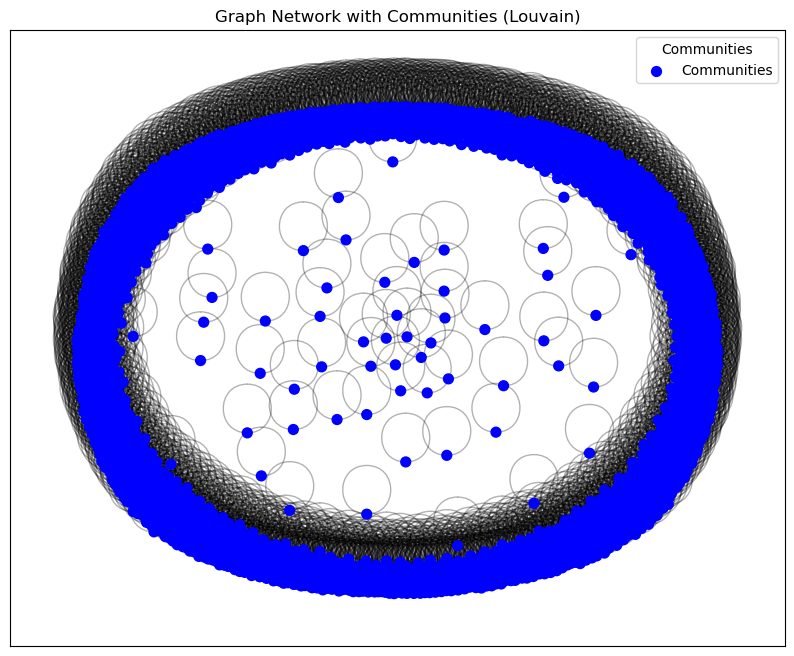

In [12]:
# Get community colors for visualization
# community_colors = [partition[node] for node in graph.nodes()]

# Visualization using Matplotlib scatter plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph, seed=42)
node_sizes = [graph.nodes[node]['size'] * 50 for node in graph.nodes]
nx.draw_networkx_nodes(graph, pos, node_color='blue', node_size=node_sizes, label='Communities')
nx.draw_networkx_edges(graph, pos, alpha=0.3)
plt.legend(title='Communities', loc='best')
plt.title('Graph Network with Communities (Louvain)')
# plt.axis('off')
plt.show()

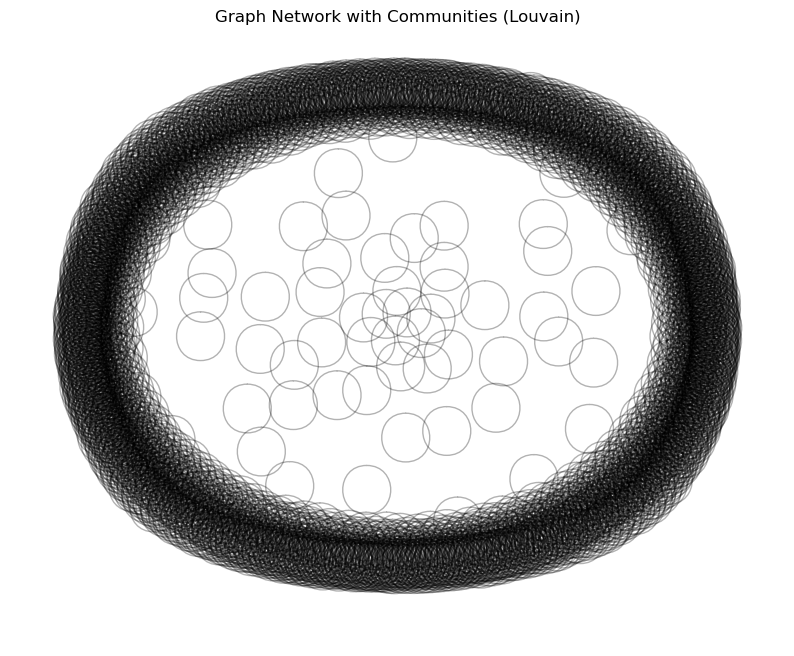

In [14]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph, seed=42)

# Get community colors for visualization
community_colors = [partition[node] for node in graph.nodes()]

node_sizes = [v * 50 for v in node_degrees.values()]
nx.draw_networkx_nodes(graph, pos, node_color=community_colors, cmap='viridis', node_size=node_sizes)
nx.draw_networkx_edges(graph, pos, alpha=0.3)
# plt.legend(title='Communities', loc='best')

plt.title('Graph Network with Communities (Louvain)')
plt.axis('off')
plt.show()


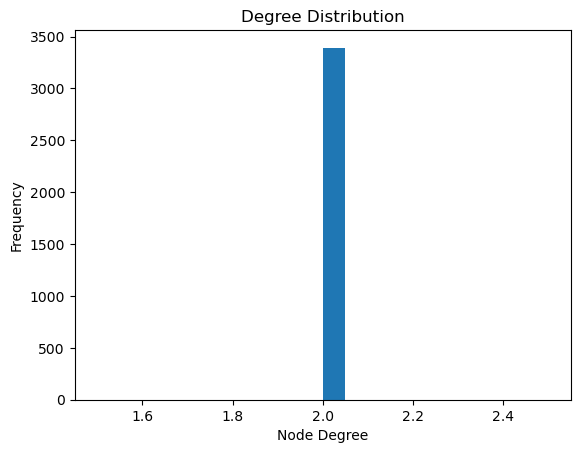

In [15]:
# Degree Distribution
degrees = dict(graph.degree())
degree_values = list(degrees.values())
plt.hist(degree_values, bins=20)
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()


### Create a graph data structure to represent the cell network

In [16]:
mask_dir = 'data/bwmask/'

In [17]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

def extract_protein_information(mask_dir, batch_size=50, min_area_threshold=10000):
    mask_files = os.listdir(mask_dir)
    num_masks = len(mask_files)

    # Process masks sequentially
    for i in range(0, num_masks, batch_size):
        batch_mask_files = mask_files[i:i + batch_size]

        protein_info = []  # Clear protein_info after each batch

        for mask_file in batch_mask_files:
            mask_path = os.path.join(mask_dir, mask_file)
            image_name, _ = os.path.splitext(mask_file)

            # Use context manager for Image.open
            with Image.open(mask_path) as img:
                mask = np.array(img)

                # Perform connected component labeling
                labeled_mask = label(mask)

                # Calculate protein localization information
                for region in regionprops(labeled_mask):
                    if region.area >= min_area_threshold:  # Set a minimum area threshold to filter out noise
                        y, x = region.centroid
                        protein_info.append({
                            'image_name': image_name,
                            'protein_id': region.label,
                            'area': region.area,
                            'centroid_x': x,
                            'centroid_y': y,
                            'bbox': region.bbox
                        })

        # Identify interacting regions
        if len(protein_info) > 1:
            interacting_pairs = set()
            for i in range(len(protein_info)):
                for j in range(i + 1, len(protein_info)):
                    bbox_i = protein_info[i]['bbox']
                    bbox_j = protein_info[j]['bbox']
                    if do_boxes_intersect(bbox_i, bbox_j):
                        interacting_pairs.add((protein_info[i]['protein_id'], protein_info[j]['protein_id']))

            # Add interacting pairs to protein_info
            for pair in interacting_pairs:
                protein_info.append({
                    'image_name': image_name,
                    'protein_id': f'interaction_{pair[0]}_{pair[1]}',
                    'area': -1,  # Indicate that it's an interaction region
                    'centroid_x': -1,
                    'centroid_y': -1,
                    'bbox': (-1, -1, -1, -1)
                })

        # Use yield to return each batch's DataFrame
        df = pd.DataFrame(protein_info)
        display(df.head())
        yield df

        
def do_boxes_intersect(bbox1, bbox2):
    # Check if two bounding boxes intersect
    y1_min, x1_min, y1_max, x1_max = bbox1
    y2_min, x2_min, y2_max, x2_max = bbox2
    return not (x1_max < x2_min or x1_min > x2_max or y1_max < y2_min or y1_min > y2_max)

In [18]:
import networkx as nx

def create_cell_network_graph(protein_data):
    # Add nodes to the graph
    for _, row in protein_data.iterrows():
        graph.add_node(str(row['protein_id']), area=row['area'], centroid=(row['centroid_x'], row['centroid_y']))

    # Add edges for interacting pairs
    for _, row in protein_data.iterrows():
        if str(row['protein_id']).startswith('interaction_'):
            _, node1, node2 = str(row['protein_id']).split('_')
            graph.add_edge(node1, node2)

    return graph

In [19]:
protein_data = pd.concat(list(extract_protein_information(mask_dir, batch_size=64, min_area_threshold=50)))
cell_network_graph = create_cell_network_graph(protein_data)
print('*'*100,'\nCell network graph info : \n\t', cell_network_graph)

,image_name,protein_id,area,centroid_x,centroid_y,bbox
0,ID192_A1_Regione-1.jp2-crop_slice_91,1,5428.0,117.542373,47.521555,"(4, 73, 103, 168)"
1,ID192_A1_Regione-1.jp2-crop_slice_91,2,324.0,186.867284,25.956790,"(17, 174, 35, 200)"
2,ID192_A1_Regione-1.jp2-crop_slice_91,3,392.0,1948.724490,30.436224,"(20, 1938, 43, 1960)"
3,ID192_A1_Regione-1.jp2-crop_slice_91,4,4078.0,191.685630,58.002697,"(24, 145, 89, 232)"
4,ID192_A1_Regione-1.jp2-crop_slice_91,5,394.0,1456.005076,44.756345,"(33, 1446, 59, 1467)"


**************************************************************************************************** 
Cell network graph info : 
	 Graph with 183686 nodes and 130341 edges


In [ ]:
# Compute node positions using the Fruchterman-Reingold force-directed layout algorithm
pos = nx.spring_layout(cell_network_graph, seed=42)

# Get node sizes based on the 'area' attribute of each node
node_sizes = [data['area'] for node, data in cell_network_graph.nodes(data=True)]

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(cell_network_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7, edge_color='gray', width=0.5, font_size=8, font_color='black', with_labels=True)

# Set plot properties
plt.title("Cell Network Graph Visualization")
plt.axis('off')
plt.show()

NetworkXError: Node 0 has no position.

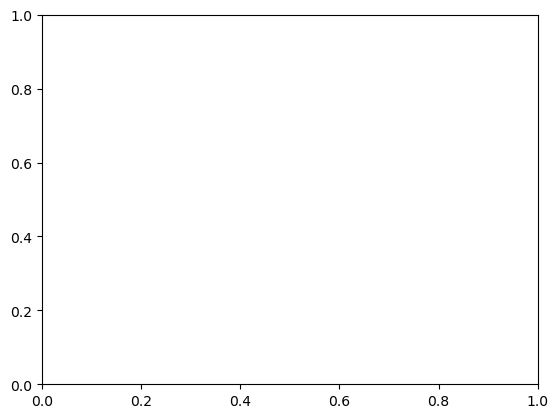

In [20]:
# Visualization of the cell_network_graph
pos = nx.get_node_attributes(cell_network_graph, 'centroid')  # Get positions of nodes

node_sizes = [data['area'] for node, data in cell_network_graph.nodes(data=True)]
nx.draw_networkx_nodes(cell_network_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)

nx.draw_networkx_edges(cell_network_graph, pos, edge_color='gray', alpha=0.5)
labels = {node: str(node) for node in cell_network_graph.nodes()}
nx.draw_networkx_labels(cell_network_graph, pos, labels, font_size=8, font_color='black')

# Set plot properties
plt.title("Cell Network Graph Visualization")
plt.axis('off')
plt.show()

# Network Analysis using Louvain Algorithm

In [ ]:
from community import community_louvain
# import community as community_louvain  # Louvain algorithm package

partition = community_louvain.best_partition(cell_network_graph)

communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

# Print the communities
print(f"Identified Communities (Protein Complexes): {len(communities)}")


# Network Visualization


#### Visualize protein complexes as separate subgraphs or colors for better understanding

In [ ]:
from tqdm import tqdm
import threading

# Get the number of protein complexes (communities)
num_communities = max(partition.values()) + 1

# Separate protein complexes into subgraphs based on community IDs
def _separate_protein_complexes(community_id):
    protein_complexes.append(cell_network_graph.subgraph([node for node in cell_network_graph.nodes if partition[node] == community_id]))

num_threads = 4
protein_complexes = []
threads = []

for community_id in tqdm(range(num_communities)):
    thread = threading.Thread(target=_separate_protein_complexes, args=(community_id,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()


In [ ]:

def filter_nodes_by_degree(graph, threshold=50):
    degree_centrality = nx.degree_centrality(graph)
    important_nodes = {node for node, centrality in degree_centrality.items() if centrality > threshold}
    return important_nodes

def create_subgraph_for_community(graph, community_id):
    return graph.subgraph([node for node in graph.nodes if partition[node] == community_id])

def limit_cells_to_display(graph, num_cells_to_display):
    return sorted(graph.nodes(), key=lambda x: nx.degree(graph, x), reverse=True)[:num_cells_to_display]

def edge_bundling_edges(graph, cells_to_display):
    return [(u, v) for u, v in graph.edges() if u in cells_to_display and v in cells_to_display]

def get_node_sizes(graph, cells_to_display, important_nodes):
    node_sizes = []
    for node in cells_to_display:
        if node in important_nodes:
            node_data = graph.nodes[node]
            node_sizes.append(node_data['area'])
        else:
            node_sizes.append(30)  # A fixed size for non-important nodes
    return node_sizes


In [ ]:
# Function to visualize the cell network graph
def visualize_cell_network_graph(graph, cells_to_display, important_nodes, pos):
    node_sizes = get_node_sizes(graph, cells_to_display, important_nodes)

    nx.draw_networkx_nodes(graph, pos, nodelist=cells_to_display, node_size=node_sizes, node_color='skyblue', alpha=0.7)
    non_important_nodes_list = [node for node in cells_to_display if node not in important_nodes]
    nx.draw_networkx_nodes(graph, pos, nodelist=non_important_nodes_list, node_size=30, node_color='gray', alpha=0.7)

    edges = list(graph.edges)
    edge_positions = np.array([(pos[u], pos[v]) for u, v in edges], dtype='f')
    
    try:
        lc = LineCollection(edge_positions, colors='gray', linewidths=0.5, alpha=0.5)
        plt.gca().add_collection(lc)
    except NameError as e:
        print(f"{e}")

    plt.title("Cell Network Graph Visualization")
    plt.axis('off')
    plt.show()


In [ ]:
import networkx as nx
import plotly.graph_objects as go

from concurrent.futures import ThreadPoolExecutor

def visualize_protein_complexes(cell_network_graph, protein_complexes, pos):
    num_communities = len(protein_complexes)
    colors = plt.cm.get_cmap('tab20', num_communities)
    
    fig = go.Figure()

    def visualize_complex(protein_complex, i):
        # Extract nodes and edges of the protein complex from the main graph
        nodes = [node for node in protein_complex.nodes() if node in cell_network_graph]
        edges = [edge for edge in cell_network_graph.edges() if edge[0] in nodes and edge[1] in nodes]

        complex_subgraph = nx.Graph()
        complex_subgraph.add_nodes_from(nodes)
        complex_subgraph.add_edges_from(edges)

        complex_pos = {node: pos[node] for node in nodes}

        node_trace = go.Scatter(x=[], y=[], mode='markers', marker=dict(size=10, color=colors(i)))
        for node, (x, y) in complex_pos.items():
            node_trace['x'] += tuple([x])
            node_trace['y'] += tuple([y])
        fig.add_trace(node_trace)

        edge_trace = go.Scatter(x=[], y=[], mode='lines')
        for u, v in complex_subgraph.edges():
            edge_trace['x'] += tuple([complex_pos[u][0], complex_pos[v][0], None])
            edge_trace['y'] += tuple([complex_pos[u][1], complex_pos[v][1], None])
        fig.add_trace(edge_trace)

    # Create a ThreadPoolExecutor to process the visualization of protein complexes in parallel
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(visualize_complex, protein_complex, i) for i, protein_complex in enumerate(protein_complexes)]
        for future in tqdm.tqdm(futures, total=len(futures)):
            future.result()

    # Set plot layout properties
    fig.update_layout(title_text="Protein Complexes Visualization", showlegend=False, xaxis=dict(showticklabels=False), yaxis=dict(showticklabels=False))
    fig.show()



In [ ]:

important_nodes = filter_nodes_by_degree(cell_network_graph, 50)
cells_to_display = limit_cells_to_display(cell_network_graph, 300)
pos = nx.get_node_attributes(cell_network_graph, 'centroid')


In [ ]:
visualize_cell_network_graph(cell_network_graph, cells_to_display, important_nodes, pos)

In [ ]:
from matplotlib.collections import LineCollection
visualize_cell_network_graph(cell_network_graph, cells_to_display, important_nodes, pos)

## Graph Network evaluation

In [ ]:
# Calculate modularity using Louvain algorithm for community detection
partition = community.best_partition(graph)
modularity = community.modularity(partition, graph)
print("Modularity:", modularity)


# Calculate overall connectivity and density
connectivity = graph.number_of_edges()
print("Connectivity:", connectivity)

density = nx.density(graph)
print("Density:", density)

# Calculate average path length and diameter
avg_path_length = nx.average_shortest_path_length(graph)
print("Average Path Length:", avg_path_length)

diameter = nx.diameter(graph)
print("Diameter:", diameter)


# Calculate clustering coefficient
clustering_coefficient = nx.average_clustering(graph)
print("Clustering Coefficient:", clustering_coefficient)

# Calculate robustness by simulating node removal
num_nodes_removed = 10
removed_nodes = np.random.choice(list(graph.nodes()), num_nodes_removed, replace=False)
robustness = 0
absent_nodes = 0
for node in removed_nodes:
    if not node:
        absent_nodes+=1
    else:
        temp_graph = graph.copy()
        temp_graph.remove_node(node)
        if nx.is_connected(temp_graph):
            robustness += 1
robustness /= num_nodes_removed
print("Robustness:", robustness)

